In [10]:
import os
print(os.listdir())

['.ipynb_checkpoints', 'avg_sal_pro.png', 'avg_sal_profiles.png', 'cleaning_historic.ipynb', 'fixed_sg195_MOTIVE_2024_timeseries.csv', 'fixed_sg195_MOTIVE_2024_timeseries.nc', 'ocldb1743899871.1986425_OSD.nc', 'ocldb1746576816.2520367_CTD.nc', 'ocldb1746576816.2520367_OSD.nc', 'sg195_MOTIVE_2024_timeseries.nc']


In [11]:
#!pip install netCDF4
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from datetime import datetime
import xarray as xr
from matplotlib.ticker import ScalarFormatter
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [14]:
# change directory to where the file is located
folder_path = input("Enter the folder path where your file is located (e.g., 'C:/Users/lydia/Seagliders/tropics_mission/tropics_data'): ")
os.chdir(folder_path)
print(f"Changed directory to: {folder_path}")

# get filename
file_name = input("Enter the NetCDF file name (e.g., sg195_MOTIVE_2024_timeseries.nc): ")

# Load the dataset
sg_df = xr.open_dataset(file_name)
print(f"Successfully opened file: {file_name}")

Enter the folder path where your file is located (e.g., 'C:/Users/lydia/Seagliders/tropics_mission/tropics_data'):  C:/Users/lydia/Seagliders/tropics_mission/tropics_data


Changed directory to: C:/Users/lydia/Seagliders/tropics_mission/tropics_data


Enter the NetCDF file name (e.g., sg195_MOTIVE_2024_timeseries.nc):  sg195_MOTIVE_2024_timeseries.nc


Successfully opened file: sg195_MOTIVE_2024_timeseries.nc


In [15]:
print("Time of first dive:", sg_df['time'][0].values)

answer = input("Does the day and time look right?")

if answer == "yes" or answer == "Yes":
    print(" Great! No offset is needed.")
else: 
    years = int(input("Years to add: "))
    months = int(input("Months to add: "))
    days = int(input("Days to add: "))

    # new time variable with offset
    sg_df['new_time'] = pd.to_datetime(sg_df['time']) + pd.DateOffset(years=years, months=months, days=days)

    print(f"Offset applied: +{years} years, +{months} months, +{days} days")
    print("New time of first dive:", sg_df['new_time'][0].values)

# if the new time of the first dive isn't correct, redo it by re-running this cell!

Time of first dive: 2005-04-06T14:24:48.526000000


Does the day and time look right? no
Years to add:  19
Months to add:  7
Days to add:  4


Offset applied: +19 years, +7 months, +4 days
New time of first dive: 2024-11-10T14:24:48.526000000


In [16]:
sg_df = sg_df.set_coords("latitude")
sg_df = sg_df.set_coords("longitude")
sg_df = sg_df.set_coords("depth")

# Extract variables (can swap with the variables that you wish to plot)
lat = np.array(sg_df['latitude'])
lon = np.array(sg_df['longitude'])
temp = np.array(sg_df['temperature'])
salinity = np.array(sg_df['salinity'])
oxygen = np.array(sg_df['dissolved_oxygen_sat'])
depth = np.array(sg_df['depth'])

time = np.array(sg_df['time'])
sg_months = pd.to_datetime(time).month # allows me to distinguish the month that the data is from 

display(sg_df) #check if everything looks right!

<xarray.Dataset> Size: 70MB
Dimensions:                                   (gps_info: 1554,
                                               sg_data_point: 366157,
                                               trajectory: 518, dive: 518,
                                               new_time: 366157)
Coordinates:
    depth                                     (sg_data_point) float32 1MB 0.9...
    ctd_time                                  (sg_data_point) datetime64[ns] 3MB ...
    ctd_depth                                 (sg_data_point) float32 1MB ...
    latitude                                  (sg_data_point) float32 1MB 0.7...
    longitude                                 (sg_data_point) float32 1MB -13...
  * trajectory                                (trajectory) int32 2kB 1 2 ... 521
  * new_time                                  (new_time) datetime64[ns] 3MB 2...
Dimensions without coordinates: gps_info, sg_data_point, dive
Data variables: (12/65)
    gps_info_dive_number                      (gps_info) int32 6kB ...
    sg_data_point_dive_number                 (sg_data_point) int32 1MB ...
    log_gps_time                              (gps_info) datetime64[ns] 12kB ...
    time                                      (sg_data_point) datetime64[ns] 3MB ...
    pressure                                  (sg_data_point) float32 1MB ...
    speed_gsm                                 (sg_data_point) float32 1MB ...
    ...                                        ...
    end_longitude                             (dive) float32 2kB ...
    depth_avg_curr_east                       (dive) float32 2kB ...
    depth_avg_curr_north                      (dive) float32 2kB ...
    depth_avg_curr_qc                         (dive) |S1 518B ...
    latlong_qc                                (dive) |S1 518B ...
    glider                                    |S12 12B ...
Attributes: (12/47)
    project:                         MOTIVE 2024
    title:                           Physical, chemical, and biological data ...
    summary:                         SG195 MOTIVE 2024
    source:                          Seaglider SG195
    references:                      http://data.nodc.noaa.gov/accession/0092291
    processing_level:                1.12
    ...                              ...
    date_modified:                   2025-04-05T17:04:42Z
    uuid:                            ef56d464-1245-11f0-80b3-07c04838153a
    base_station_version:            3.0.2
    base_station_micro_version:      0
    quality_control_version:         1.12
    Conventions:                     CF-1.6

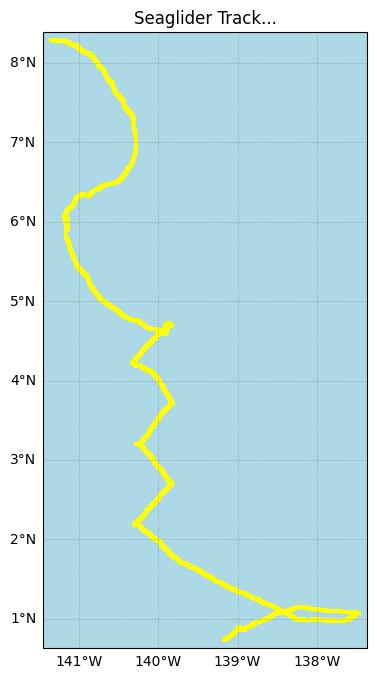

In [17]:
plt.figure(figsize=(10, 8))

# Set up a map projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.grid()

# Zoom in to your data bounds with a variable buffer
buffer = 0.10  # degrees
ax.set_extent([lon.min()-buffer, lon.max()+buffer,
               lat.min()-buffer, lat.max()+buffer],
              crs=ccrs.PlateCarree())

# Add gridlines
grid = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
grid.top_labels = False
grid.right_labels = False
# uncomment these for a more zoomed in range
#grid.xlocator = plt.FixedLocator(np.arange(lon.min(), lon.max(), 0.05))
#grid.ylocator = plt.FixedLocator(np.arange(lat.min(), lat.max(), 0.05))


# Add land and ocean
ax.add_feature(cfeature.LAND, facecolor='lightgreen')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)

# Plot your glider track
ax.scatter(lon, lat, c="yellow", s=10, marker = '_', transform=ccrs.PlateCarree())

ax.set_title("Seaglider Track...")
plt.show()


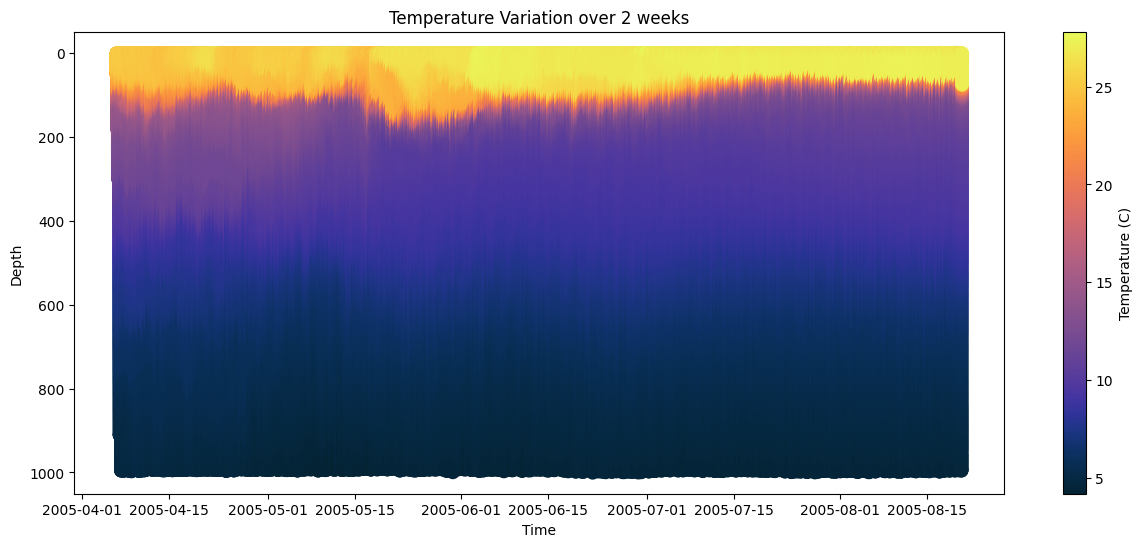

In [18]:
plt.figure(figsize=(15, 6))
scatter = plt.scatter(time, depth, c=temp, cmap= cm.cm.thermal, s=80)
plt.colorbar(label="Temperature (C)")
plt.xlabel("Time")
plt.ylabel("Depth")
plt.gca().invert_yaxis()


plt.title("Temperature Variation...")

plt.show()

In [ ]:
plt.figure(figsize=(15, 6))
scatter = plt.scatter(time, depth, c=salinity, cmap= cm.cm.haline, s=80)
plt.colorbar(label="Salinity (PSU)")
plt.xlabel("Time")
plt.ylabel("Depth")
plt.gca().invert_yaxis()


plt.title("Salinity Variation...")

plt.show()

In [ ]:
plt.figure(figsize=(15, 6))
scatter = plt.scatter(time, depth, c=oxygen, cmap= cm.cm.oxy, s=80)
plt.colorbar(label="Dissolved Oxygen Saturation")
plt.xlabel("Time")
plt.ylabel("Depth")
plt.gca().invert_yaxis()


plt.title("Dissolved Oxygen Saturation...")

plt.show()